# Project: Vehicle detection

## Imports, named constans and parameters

In [1109]:
import os
import glob
import time
import pickle
import cv2
import collections
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

TEST_IMAGE = 'test_images/test5.jpg'
OUTPUT_IMAGE_DIR = 'output_images'
TRAINING_IMAGES = 'data/*/*/*.png'
TRAINING_RESULT = 'training_result.p'

X_RANGE = [512, None]
Y_RANGE = [400, 656]
SCALE = 1.5

## Step 1

* Extract color features

### Step 1 Functions

In [1110]:
def getSpatialFeatures(image, size=(32, 32)):
    '''
    Create the feature vector using cv2.resize().ravel()
    '''
    color1 = cv2.resize(image[:,:,0], size).ravel()
    color2 = cv2.resize(image[:,:,1], size).ravel()
    color3 = cv2.resize(image[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def getHistFeatures(image, numberOfBins=32, binRange=(0, 256)):
    '''
    Compute the histogram of the color channels separately
    '''
    hist1 = np.histogram(image[:,:,0], bins=numberOfBins, range=binRange)
    hist2 = np.histogram(image[:,:,1], bins=numberOfBins, range=binRange)
    hist3 = np.histogram(image[:,:,2], bins=numberOfBins, range=binRange)
    return np.concatenate((hist1[0], hist2[0], hist3[0]))


## Step 2

* Extract gradient features, especially HOG features

### Step 2 Functions

In [1111]:
def getGradientFeatures(image, orientations, pixelPerCell, cellPerBlock, visualise=False, featureVector=True):
    '''
    Get HOG features
    '''
    # Call with two outputs if visualise==True
    if visualise == True:
        features, hogImage = hog(image, orientations=orientations, pixels_per_cell=(pixelPerCell, pixelPerCell), 
                                 cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False, 
                                 visualise=visualise, feature_vector=featureVector)
        return features, hogImage
    # Otherwise call with one output
    else:
        features = hog(image, orientations=orientations, pixels_per_cell=(pixelPerCell, pixelPerCell),
                       cells_per_block=(cellPerBlock, cellPerBlock), transform_sqrt=False, 
                       visualise=visualise, feature_vector=featureVector)
        return features

    
def getHogFeatures(image, orientations, pixelPerCell, cellPerBlock, visualise, featureVector, hogChannel):
    '''
    Get HOG features for all channels or a single channel
    '''
    hogFeatures = []
    if hogChannel == 'ALL':
        for channel in range(image.shape[2]):
            hogFeatures.append(getGradientFeatures(image[:,:,channel], orientations, 
                                                   pixelPerCell, cellPerBlock, visualise, featureVector))
        hogFeatures = np.ravel(hogFeatures)        
    else:
        hogFeatures = getGradientFeatures(image[:,:,hogChannel], orientations, 
                                          pixelPerCell, cellPerBlock, visualise, featureVector)
    return hogFeatures
    

## Step 3

* Define functions to accommodate the feature functions and extract features for each

### Step 3 Functions

In [1112]:
def convertColor(image, colorSpace):
    '''
    Convert the color space of the image
    '''
    featureImage = image
    if colorSpace == 'HSV':
        featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif colorSpace == 'LUV':
        featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif colorSpace == 'HLS':
        featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif colorSpace == 'YUV':
        featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif colorSpace == 'YCrCb':
        featureImage = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return featureImage

def getFeatures(image, featureFunctionAndArguments):
    mixedFeatures = []
    for functionAndArguments in featureFunctionAndArguments:
        featureFunction = functionAndArguments[0]
        arguments = functionAndArguments[1]
        mixedFeatures.append(featureFunction(image, **arguments))
    return mixedFeatures

def extractFeatures(images, colorSpace, featureFunctionAndArguments):
    '''
    Extract features of the images using the featureFunctions
    '''
    # Apply color conversion if other than 'RGB'
    features = []
    for file in images:
        image = mpimg.imread(file)
        if colorSpace != 'RGB':
            featureImage = convertColor(image, colorSpace)
        else:
            featureImage = np.copy(image)
        
        mixedFeatures = getFeatures(featureImage, featureFunctionAndArguments)
        features.append(np.concatenate(mixedFeatures))
    
    return features


## Step 4

* Train features using images from the GTI vehicle image database and the KITTI vision benchmark suite

### Step 4 Functions

In [725]:
def trainClassifier(colorSpace, featureFunctionAndArguments, defaultSampleSize=10000):
    '''
    Train a classifier using features extracted from the training samples
    '''
    # Separate the traning data into cars and notcars
    images = glob.glob(TRAINING_IMAGES)
    cars = []
    notcars = []
    for file in images:
        if 'non-vehicles' in file:
            notcars.append(file)
        else:
            cars.append(file)
            
    sampleSize = min(defaultSampleSize, min(len(cars), len(notcars)))
    cars = np.random.choice(cars, sampleSize)
    notcars = np.random.choice(notcars, sampleSize)
    
    print('Sample size: %d' % sampleSize)
            
    start = time.time()
    carFeatures = extractFeatures(cars, colorSpace, featureFunctionAndArguments)
    notcarFeatures = extractFeatures(notcars, colorSpace, featureFunctionAndArguments)
    end = time.time()
    print(round(end-start, 2), 'Seconds to extract features...')
    
    # Create an array stack of feature vectors
    # Fit a per-column scaler
    # Apply the scaler to X
    X = np.vstack((carFeatures, notcarFeatures)).astype(np.float64)                        
    xScaler = StandardScaler().fit(X)
    scaledX = xScaler.transform(X)

    # Define the labels vector
    # Split up data into randomized training and test sets
    y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notcarFeatures))))
    randState = np.random.randint(0, 100)
    xTrain, xTest, yTrain, yTest = train_test_split(scaledX, y, test_size=0.2, random_state=randState)
    print('Feature vector length:', len(xTrain[0]))
    
    # Train the model using a linear SVC 
    svc = LinearSVC()
    start=time.time()
    svc.fit(xTrain, yTrain)
    end = time.time()
    print(round(end-start, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(xTest, yTest), 4))

    # Make predictions
    start=time.time()
    numberOfPredicts = 10
    print('SVC predicts:        ', svc.predict(xTest[0:numberOfPredicts]))
    print('For these',numberOfPredicts, 'labels: ', yTest[0:numberOfPredicts])
    end = time.time()
    print(round(end-start, 5), 'Seconds to predict', numberOfPredicts,'labels with SVC')
    
    # Save the training result
    result = {'svc' : svc, 'scaler' : xScaler}
    pickle.dump(result, open(TRAINING_RESULT, 'wb'))
    print('Training result saved')
    
    return svc, xScaler


### Step 4 Test

* Feature extraction and training

In [912]:
SAMPLE_SIZE = 3000
COLOR_SPACE = 'YCrCb'
HOG_ARGUMENTS = {'orientations' : 9, 
                 'pixelPerCell' : 8, 
                 'cellPerBlock' : 2, 
                 'visualise' : False, 
                 'featureVector' : False, 
                 'hogChannel' : 'ALL'}
SPATIAL_ARGUMENTS = {'size' : (32, 32)}
HIST_ARGUMENTS = {'numberOfBins' : 32, 'binRange' : (0, 256)}

# Note: the order of extracting features affects the implementation of the car detector
FEATURE_FUNCTIONS_AND_ARGUMENTS = [(getSpatialFeatures, SPATIAL_ARGUMENTS),
                                   (getHistFeatures, HIST_ARGUMENTS),
                                   (getHogFeatures, HOG_ARGUMENTS)] 

trainClassifier(COLOR_SPACE, FEATURE_FUNCTIONS_AND_ARGUMENTS, SAMPLE_SIZE)


Sample size: 3000
58.64 Seconds to extract features...
Feature vector length: 8460
19.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9925
SVC predicts:         [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  1.]
0.01783 Seconds to predict 10 labels with SVC
Training result saved


(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0), StandardScaler(copy=True, with_mean=True, with_std=True))

## Step 5

* Detect cars using the feature vectors
* Produce bounding boxes as a result of the detection

### Step 5 Funcitons


In [1113]:
def slideWindow(image, xRange=[None, None], yRange=[None, None], windowSize=(64, 64), overlapRatio=(0.5, 0.5)):
    '''
    Find and generate windows to search features
    '''
    # If x and/or y start/stop positions not defined, set to image size
    xAxis = xRange.copy()
    yAxis = yRange.copy()
    
    if xAxis[0] == None:
        xAxis[0] = 0
    if xAxis[1] == None:
        xAxis[1] = image.shape[1]
    if yAxis[0] == None:
        yAxis[0] = 0
    if yAxis[1] == None:
        yAxis[1] = image.shape[0]
        
    # Compute the span of the region to be searched
    xSpan = xAxis[1] - xAxis[0]
    ySpan = yAxis[1] - yAxis[0]
    
    # Compute the number of pixels per step in x/y
    xPixelPerStep = np.int(windowSize[0] * (1 - overlapRatio[0]))
    yPixelPerStep = np.int(windowSize[1] * (1 - overlapRatio[1]))
    
    # Compute the number of windows in x/y
    xBuffer = np.int(windowSize[0] * (overlapRatio[0]))
    yBuffer = np.int(windowSize[1] * (overlapRatio[1]))
    xWindows = np.int((xSpan - xBuffer) / xPixelPerStep) 
    yWindows = np.int((ySpan - yBuffer) / yPixelPerStep) 

    # Loop through finding x and y window positions
    windowList = []
    for ys in range(yWindows):
        for xs in range(xWindows):
            # Calculate window position
            xStart = xs * xPixelPerStep + xAxis[0]
            xEnd = xStart + windowSize[0]
            yStart = ys * yPixelPerStep + yAxis[0]
            yEnd = yStart + windowSize[1]
            windowList.append(((xStart, yStart), (xEnd, yEnd)))
            
    return windowList

def searchWindows(image, colorSpace, windows, svc, xScaler, hogArguments, spatialArguments, histArguments):
    '''
    Detect vehicles using the features extracted from the image
    '''
    hotWindows = []
    for window in windows:
        #3) Extract the test window from original image
        testImage = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window
        testImage = convertColor(testImage, colorSpace)
        
        hogArguments['hogChannel'] = 0
        hogFeature1 = getHogFeatures(testImage, **hogArguments)
        hogArguments['hogChannel'] = 1
        hogFeature2 = getHogFeatures(testImage, **hogArguments)
        hogArguments['hogChannel'] = 2
        hogFeature3 = getHogFeatures(testImage, **hogArguments)
        hogFeatures = np.hstack((hogFeature1.ravel(), hogFeature2.ravel(), hogFeature3.ravel()))
        
        spatialFeatures = getSpatialFeatures(testImage, **spatialArguments)
        histFeatures = getHistFeatures(testImage, **histArguments)

        testFeatures = xScaler.transform(np.hstack((spatialFeatures, histFeatures, hogFeatures)).reshape(1, -1))        
        
        prediction = svc.predict(testFeatures)
        if prediction == 1:
            hotWindows.append(window)
            
    return hotWindows

def drawBoxes(image, boundingBoxes, color=(0,0,255), thick=6):
    destination = np.copy(image)
    for boundingBox in boundingBoxes:
        cv2.rectangle(destination, boundingBox[0], boundingBox[1], color, thick)
    return destination


### Step 5 Test 1

* Bounding box production and drawing using searchWindows()


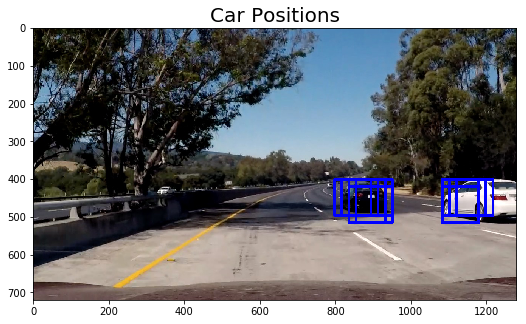

In [1114]:
image = mpimg.imread(TEST_IMAGE)
output = np.copy(image)

trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

image = image.astype(np.float32)/255
windows = slideWindow(image, X_RANGE, Y_RANGE, windowSize=(96, 96), overlapRatio=(0.8, 0.8))
boundingBoxes = searchWindows(image, COLOR_SPACE, windows, svc, xScaler, HOG_ARGUMENTS, SPATIAL_ARGUMENTS, HIST_ARGUMENTS)
output = drawBoxes(output, boundingBoxes)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(output)
ax.set_title('Car Positions', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'detected_bounding_boxes1.jpg'))


In [1115]:
def findCars(image, colorSpace, yRange, scale, svc, xScaler, hogArguments, spatialArguments, histArguments):
    '''
    Detect vehicles using the features extracted from the image with HOG sub-sampling
    '''
    yAxis = yRange.copy()

    image = image.astype(np.float32)/255    
    searchSpace = image[yAxis[0]:yAxis[1],:,:]
    searchSpace = convertColor(searchSpace, colorSpace)
    
    if scale != 1:
        imshape = searchSpace.shape
        searchSpace = cv2.resize(searchSpace, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    searchSpaceChannel = searchSpace[:,:,0]

    # Define blocks and steps as above
    pixelPerCell = hogArguments['pixelPerCell']
    cellPerBlock = hogArguments['cellPerBlock']
    xBlocks = (searchSpaceChannel.shape[1] // pixelPerCell) - cellPerBlock + 1
    yBlocks = (searchSpaceChannel.shape[0] // pixelPerCell) - cellPerBlock + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    blockPerWindow = (window // pixelPerCell) - cellPerBlock + 1
    
    # Instead of overlap, define how many cells to step
    cellPerStep = 2
    xSteps = (xBlocks - blockPerWindow) // cellPerStep
    ySteps = (yBlocks - blockPerWindow) // cellPerStep
    
    # Compute individual channel HOG features for the entire image
    hogArguments['hogChannel'] = 0
    hog1 = getHogFeatures(searchSpace, **hogArguments)
    hogArguments['hogChannel'] = 1
    hog2 = getHogFeatures(searchSpace, **hogArguments)
    hogArguments['hogChannel'] = 2
    hog3 = getHogFeatures(searchSpace, **hogArguments)
    
    boundingBoxes = []
    for xb in range(xSteps):
        for yb in range(ySteps):
            yPosition = yb * cellPerStep
            xPosition = xb * cellPerStep

            # Extract HOG for this patch
            hogFeature1 = hog1[yPosition:yPosition + blockPerWindow, xPosition:xPosition + blockPerWindow].ravel() 
            hogFeature2 = hog2[yPosition:yPosition + blockPerWindow, xPosition:xPosition + blockPerWindow].ravel() 
            hogFeature3 = hog3[yPosition:yPosition + blockPerWindow, xPosition:xPosition + blockPerWindow].ravel() 
            hogFeatures = np.hstack((hogFeature1, hogFeature2, hogFeature3))

            xLeft = xPosition * pixelPerCell
            yTop = yPosition * pixelPerCell

            # Extract the image patch
            subImage = cv2.resize(searchSpace[yTop:yTop + window, xLeft:xLeft + window], (64,64))
          
            # Get color features
            spatialFeatures = getSpatialFeatures(subImage, **spatialArguments)
            histFeatures = getHistFeatures(subImage, **histArguments)

            # Scale features and make a prediction
            testFeatures = xScaler.transform(np.hstack((spatialFeatures, histFeatures, hogFeatures)).reshape(1, -1))
            testPrediction = svc.predict(testFeatures)

            if testPrediction == 1:
                xLeftScaled = np.int(xLeft * scale)
                yTopScaled = np.int(yTop * scale)
                windowScaled = np.int(window * scale)
                point1 = (xLeftScaled, yTopScaled + yAxis[0])
                point2 = (xLeftScaled + windowScaled, yTopScaled + windowScaled + yAxis[0])
                boundingBoxes.append((point1, point2))
                
    return boundingBoxes


### Step 5 Test

* Bounding box production and drawing using findCars()


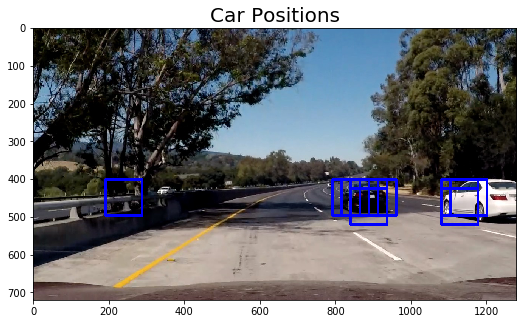

In [1116]:
image = mpimg.imread(TEST_IMAGE)

trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

boundingBoxes = findCars(image, COLOR_SPACE, Y_RANGE, SCALE, svc, xScaler, HOG_ARGUMENTS, SPATIAL_ARGUMENTS, HIST_ARGUMENTS)
output = drawBoxes(image, boundingBoxes)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(output)
ax.set_title('Car Positions', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'detected_bounding_boxes2.jpg'))


## Step 6

* Filter the bounding boxs to remove false positives

### Step 6 functions

In [1117]:
def addHeat(heatmap, boundingBoxes):
    '''
    Put a mark on each bounding box to make a heatmap
    '''
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    for boundingBox in boundingBoxes:
        heatmap[boundingBox[0][1]:boundingBox[1][1], boundingBox[0][0]:boundingBox[1][0]] += 1
    return heatmap
    
def applyThreshold(heatmap, threshold):
    '''
    Filter the heatmap by the threshold
    '''
    heatmap[heatmap <= threshold] = 0
    return heatmap

def drawLabeledBoundingBoxes(image, labels):
    '''
    Find and draw bounding boxes 
    '''
    # Find pixels with each carNumber label value
    # Identify x and y values of those pixels
    # Define a bounding box based on min/max x and y
    for carNumber in range(1, labels[1]+1):
        nonzero = (labels[0] == carNumber).nonzero()
        nonzeroY = np.array(nonzero[0])
        nonzeroX = np.array(nonzero[1])
        boundingBox = ((np.min(nonzeroX), np.min(nonzeroY)), (np.max(nonzeroX), np.max(nonzeroY)))
        cv2.rectangle(image, boundingBox[0], boundingBox[1], (0, 255, 0), 6)
    return image

def filterBoundingBoxes(image, boundingBoxes, hotboxes, maxFrames, threshold):
    '''
    Filter and draw bounding boxes
    '''
    hotbox = np.zeros_like(image[:,:,0]).astype(np.float)
    hotbox = addHeat(hotbox, boundingBoxes)
    hotboxes.append(hotbox)
    if len(hotboxes) == maxFrames:
        hotbox = sum(hotboxes)
    hotbox = applyThreshold(hotbox, threshold)
    heatmap = np.clip(hotbox, 0, 255)
    labels = label(heatmap)
    output = drawLabeledBoundingBoxes(image, labels)
    return output, heatmap


### Step 6 Test 1

* Filtering of false positives using searchWindows()


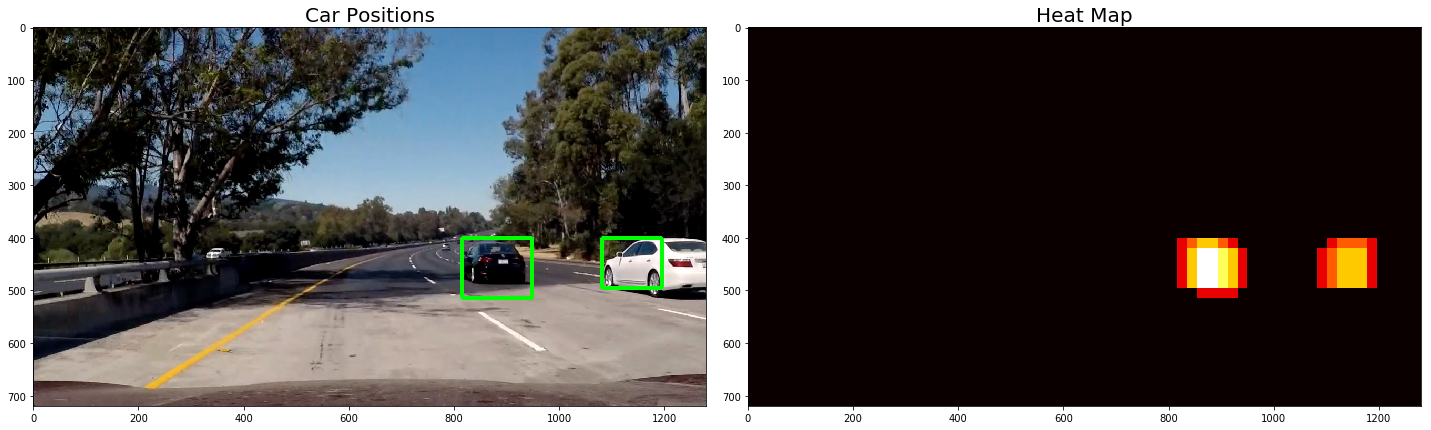

In [1118]:
threshold = 1
maxFrames = 1

image = mpimg.imread(TEST_IMAGE)
output = np.copy(image)

hotboxes = collections.deque(maxlen=maxFrames)
trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

image = image.astype(np.float32)/255
windows = slideWindow(image, X_RANGE, Y_RANGE, windowSize=(96, 96), overlapRatio=(0.8, 0.8))
boundingBoxes = searchWindows(image, COLOR_SPACE, windows, svc, xScaler, HOG_ARGUMENTS, SPATIAL_ARGUMENTS, HIST_ARGUMENTS)
output, heatmap = filterBoundingBoxes(output, boundingBoxes, hotboxes, maxFrames, threshold)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(output)
ax1.set_title('Car Positions', fontsize=20)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'detected_cars1.jpg'))


### Step 6 Test 2

* Filtering of false positives using findCars()


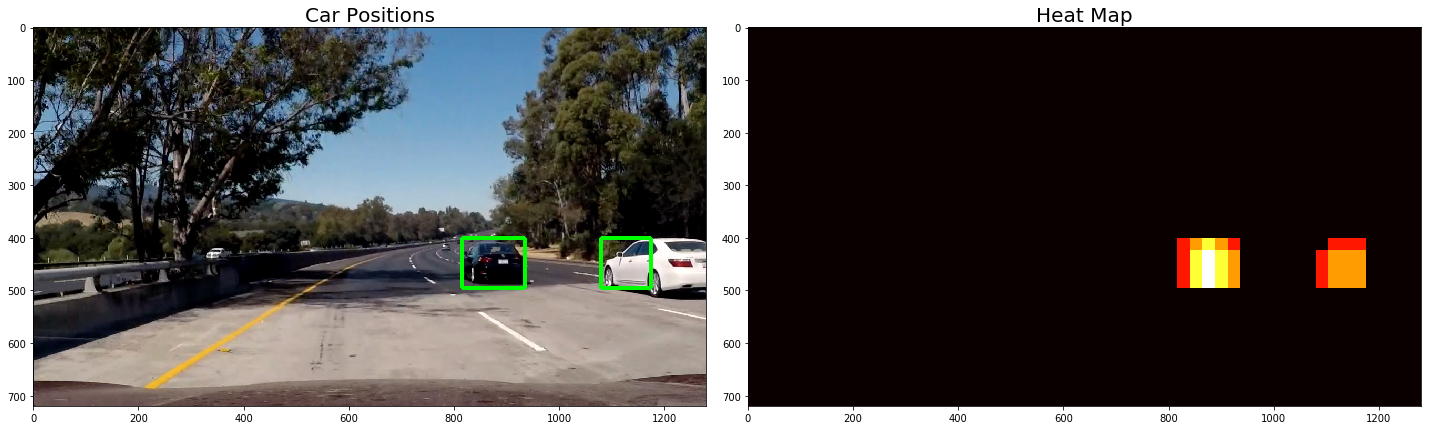

In [1119]:
threshold = 1
maxFrames = 1

image = mpimg.imread(TEST_IMAGE)

hotboxes = collections.deque(maxlen=maxFrames)
trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

boundingBoxes = findCars(image, COLOR_SPACE, Y_RANGE, SCALE, svc, xScaler, HOG_ARGUMENTS, SPATIAL_ARGUMENTS, HIST_ARGUMENTS)
output, heatmap = filterBoundingBoxes(image, boundingBoxes, hotboxes, maxFrames, threshold)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.tight_layout()
ax1.imshow(output)
ax1.set_title('Car Positions', fontsize=20)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=20)

fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, 'detected_cars2.jpg'))


## Pipeline to process a video


In [1129]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1130]:
THRESHOLD_1 = 10
MAX_FRAMES_1 = 15

hotboxes = collections.deque(maxlen=MAX_FRAMES_1)
trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

def pipeline1(image):
    output = np.copy(image)
    image = image.astype(np.float32)/255
    windows = slideWindow(image, X_RANGE, Y_RANGE, windowSize=(96, 96), overlapRatio=(0.8, 0.8))
    boundingBoxes = searchWindows(image, COLOR_SPACE, windows, svc, xScaler, HOG_ARGUMENTS, SPATIAL_ARGUMENTS, HIST_ARGUMENTS)
    output, heatmap = filterBoundingBoxes(output, boundingBoxes, hotboxes, MAX_FRAMES_1, THRESHOLD_1)
    return output


In [1131]:
testOutput1 = 'test1.mp4'
clipTest = VideoFileClip("test_video.mp4")
testClip = clipTest.fl_image(pipeline1)
%time testClip.write_videofile(testOutput1, audio=False)


[MoviePy] >>>> Building video test1.mp4
[MoviePy] Writing video test1.mp4


 97%|█████████▋| 38/39 [00:51<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test1.mp4 

CPU times: user 51.3 s, sys: 170 ms, total: 51.5 s
Wall time: 53.5 s


In [1132]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(testOutput1))

In [1133]:
THRESHOLD_2 = 10
MAX_FRAMES_2 = 15

hotboxes = collections.deque(maxlen=MAX_FRAMES_2)
trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

def pipeline2(image):
    boundingBoxes = findCars(image, COLOR_SPACE, Y_RANGE, SCALE, svc, xScaler, HOG_ARGUMENTS, SPATIAL_ARGUMENTS, HIST_ARGUMENTS)
    output, heatmap = filterBoundingBoxes(image, boundingBoxes, hotboxes, MAX_FRAMES_2, THRESHOLD_2)
    return output


In [1134]:
testOutput2 = 'test2.mp4'
clipTest = VideoFileClip("test_video.mp4")
testClip = clipTest.fl_image(pipeline2)
%time testClip.write_videofile(testOutput2, audio=False)


[MoviePy] >>>> Building video test2.mp4
[MoviePy] Writing video test2.mp4


 97%|█████████▋| 38/39 [00:15<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test2.mp4 

CPU times: user 14.7 s, sys: 180 ms, total: 14.8 s
Wall time: 16.8 s


In [1135]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(testOutput2))

In [1136]:

hotboxes = collections.deque(maxlen=MAX_FRAMES_1)
trained = pickle.load(open(TRAINING_RESULT, "rb"))
svc = trained['svc']
xScaler = trained['scaler']

projectOutput = 'project.mp4'
clipProject = VideoFileClip("project_video.mp4")
projectClip = clipProject.fl_image(pipeline1)
%time projectClip.write_videofile(projectOutput, audio=False)


[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████▉| 1260/1261 [44:20<00:01,  1.38s/it]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

CPU times: user 43min 52s, sys: 8.37 s, total: 44min
Wall time: 44min 21s


In [1137]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(projectOutput))